
[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\srata\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


📥 Loading CSV...
✅ Using 10263 samples.
Processing 10263 images...


Preprocessing Images: 100%|█████████████████████████████████████████████████████| 10263/10263 [00:10<00:00, 958.41it/s]



🔧 Building and training autoencoder...
Epoch 1/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - loss: 0.0232 - val_loss: 0.0076
Epoch 2/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 3/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 4/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 5/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 6/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 7/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 8/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 9/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 10/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - loss: 0.0075 - val_loss: 0.0076
📦 Saved encoder model to: autoencoder_encoder.keras

🎯 Extracting encoded featu

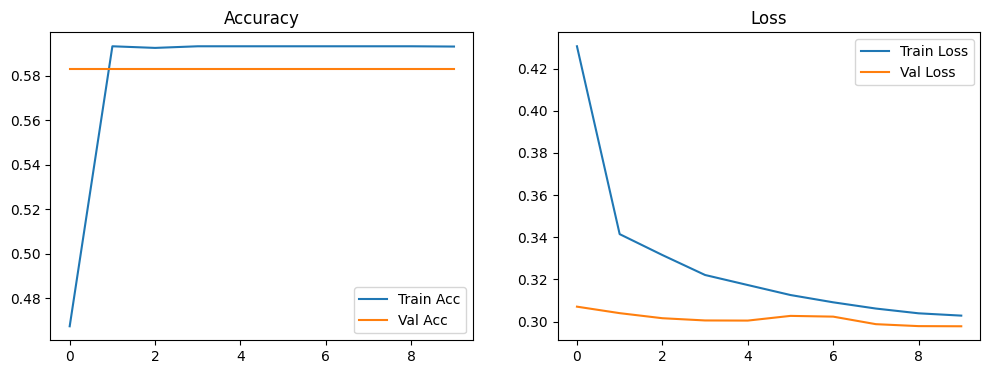

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

IMAGE_RESIZE = (128, 128)
TRAIN_IMAGE_FOLDER = "images_training_rev1/"
CSV_PATH = "training_solutions_rev1.csv"
MODEL_SAVE_PATH = "final(sample)_galaxy_model.keras"
ENCODER_SAVE_PATH = "autoencoder_encoder.keras"
EPOCHS = 10
BATCH_SIZE = 16

#Preprocessing
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        return None
    img = cv2.resize(img, IMAGE_RESIZE)
    img = img / 255.0  # Normalize
    return np.array(img, dtype=np.float32)

def preprocess_data_img(data_subset):
    x, y, missing = [], [], 0
    print(f"Processing {len(data_subset)} images...")

    for _, row in tqdm(data_subset.iterrows(), total=len(data_subset), desc="Preprocessing Images"):
        img_path = os.path.join(TRAIN_IMAGE_FOLDER, f"{int(row['GalaxyID'])}.jpg")
        if os.path.exists(img_path):
            processed_img = preprocess_image(img_path)
            if processed_img is not None:
                x.append(processed_img)
                y.append(row.iloc[1:].values.astype(np.float32))
            else:
                missing += 1
        else:
            missing += 1

    if len(x) == 0:
        raise ValueError("No images were processed successfully.")
    
    return np.array(x), np.array(y)

#autoencoder
def build_autoencoder():
    input_img = Input(shape=(128, 128, 3))
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Feature representation (32, 32, 64)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

#cnn
def build_classifier_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(37, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

#plotting
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

#evaluation
def evaluate_model(model, x_test, y_test):
    y_pred_probs = model.predict(x_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    y_true = (y_test > 0.5).astype(int)
    print("\nMulti-label Classification Report:")
    print(classification_report(y_true.flatten(), y_pred.flatten(), zero_division=0))

#Driver Code
def main():
    data = pd.read_csv(CSV_PATH)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    data = data.iloc[:len(data)//6]  # Use half of the data
    print(f"Using {len(data)} samples.")

    x, y = preprocess_data_img(data)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    print("\nBuilding and training autoencoder...")
    autoencoder, encoder = build_autoencoder()
    autoencoder.fit(x_train, x_train,
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(x_test, x_test),
                    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])
    
    encoder.save(ENCODER_SAVE_PATH)
    print(f"Saved encoder model to: {ENCODER_SAVE_PATH}")

    print("\nExtracting encoded features for classification...")
    x_train_encoded = encoder.predict(x_train)
    x_test_encoded = encoder.predict(x_test)

    if os.path.exists(MODEL_SAVE_PATH):
        print(f"\nLoading existing classifier from: {MODEL_SAVE_PATH}")
        model = load_model(MODEL_SAVE_PATH)
        evaluate_model(model, x_test_encoded, y_test)
    else:
        print("\nTraining classifier on encoded features...")
        model = build_classifier_model(input_shape=x_train_encoded.shape[1:])
        history = model.fit(x_train_encoded, y_train,
                            validation_data=(x_test_encoded, y_test),
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            callbacks=[
                                EarlyStopping(patience=3, restore_best_weights=True),
                                ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True)
                            ])
        model.save(MODEL_SAVE_PATH)
        evaluate_model(model, x_test_encoded, y_test)
        plot_history(history)

if __name__ == "__main__":
    main()


In [27]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# ---------------------- CONFIG ----------------------
IMAGE_RESIZE = (128, 128)
TRAIN_IMAGE_FOLDER = "images_training_rev1/"
CSV_PATH = "training_solutions_rev1.csv"
MODEL_SAVE_PATH = "final(auto)_galaxy_model.keras"
ENCODER_SAVE_PATH = "autoencoder_encoder.keras"
EPOCHS = 10
BATCH_SIZE = 16

def classify_uploaded_image(image_path, threshold=0.3):
    encoder = load_model(ENCODER_SAVE_PATH)
    classifier = load_model(MODEL_SAVE_PATH)

    img = preprocess_image(image_path)
    if img is None:
        raise ValueError("Failed to load image.")
    
    img_exp = np.expand_dims(img, axis=0)
    encoded = encoder.predict(img_exp)
    preds = classifier.predict(encoded)[0]

    galaxy_labels = [
        "Smooth", "Features or Disk", "Star or Artifact",
        "Completely Round", "Between Round and Oval", "Cigar-Shaped",
        "Edge-on with Bulge", "Edge-on without Bulge",
        "No Bulge", "Small Bulge", "Moderate Bulge", "Large Bulge",
        "Bar Present", "No Bar",
        "Spiral Pattern", "No Spiral Arms",
        "Tightly Wound Arms", "Medium Wound Arms", "Loose Spiral Arms",
        "1 Spiral Arm", "2 Spiral Arms", "3 Spiral Arms", "4 Spiral Arms",
        "More than 4 Arms", "Unclear Spiral Arms",
        "Merging Galaxy", "Irregular Galaxy",
        "Lenses or Arcs", "Disturbed Structure", "Tidal Debris",
        "Dust Lanes", "Compact Galaxy", "Overlapping Galaxies",
        "Satellite or Companion Galaxy", "Ring", "Disturbed", "Other"
    ]

    print(f"\nPredicted Labels (Threshold > {threshold}):")
    for i, label in enumerate(galaxy_labels):
        if preds[i] > threshold:
            print(f"✅ {label} - {preds[i]:.2f}")


if __name__ == "__main__":
    # Uncomment below if you want to train the model first
    # main()

    test_img_path = "images_training_rev1/100008.jpg"  # Replace with your image path
    classify_uploaded_image(test_img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Predicted Labels (Threshold > 0.3):
✅ Smooth - 0.43
✅ Features or Disk - 0.55
✅ Between Round and Oval - 0.44
✅ Edge-on with Bulge - 0.33
✅ Spiral Pattern - 0.77
